In [1]:
from additional_test_set import AdditionalTestSet

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from imblearn.ensemble import BalancedRandomForestClassifier

from simple_ml_models import *
from utils import *
from additional_test_set_visualisation import Visualisation


2023-02-12 16:44:33.775536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data_path = "data/SingleCell_new_split/newSplitTrainCounts.tsv"
test_data_path = "data/SingleCell_new_split/newSplitTestACounts.tsv"
train_classes_path = "data/SingleCell_new_split/newSplitTrainSamples.tsv"
test_classes_path = "data/SingleCell_new_split/newSplitTestASamples.tsv"
SEED = 42

data_object = AdditionalTestSet(
    train_data_path, test_data_path, train_classes_path, test_classes_path
)
data_object.summary()

Total cells number in train data: 176
CTC cells number in train data: 138
WBC cells number in train data: 38

Total cells number in test data: 181
CTC cells number in test data: 132
WBC cells number in test data: 43
CTC-WBC cells number in test data: 6


In [3]:
cut_by_mean_train_data, cut_by_mean_test_data = AdditionalTestSet.cut_data_by_mean(
    data_object.train_data, data_object.test_data, threshold=0.3
)
(
    cut_by_mean_max_train_data,
    cut_by_mean_max_test_data,
) = AdditionalTestSet.cut_data_by_max(
    cut_by_mean_train_data, cut_by_mean_test_data, threshold=5
)
print(f"Feature number: {len(cut_by_mean_max_train_data.columns)}")

Feature number: 67


In [4]:
cut_by_mean_with_classes_train_data, cut_by_mean_with_classes_test_data = data_object.cut_data_by_mean_with_classes(
    data_object.train_data, data_object.test_data, threshold=1.6
)
print(f"Feature number: {len(cut_by_mean_with_classes_train_data.columns)}")

Feature number: 67


### LightGBM

In [5]:
lgbm_clf = LGBMClassifier(
    boosting_type="gbdt",
    min_child_weight=0.01,
    max_depth=10,
    num_leaves=16,
    n_estimators=2000,
    subsample_for_bin=10000,
    is_unbalance=True,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [6]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()


Validation balanced accuracy 0.9248420661464141
Training balanced accuracy 1.0

Validation roc auc 0.9801653660349312
Training roc auc 1.0

Validation precision 0.9703488788595171
Training precision 1.0

Validation recall 0.9565217391304347
Training recall 1.0

Validation f1 0.9632045373980858
Training f1 1.0



In [7]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.892736771149309

Test roc auc 0.9798337265475788

Test precision 0.9455373217603378

Test recall 0.9637681159420289

Test f1 score 0.9544661901559636


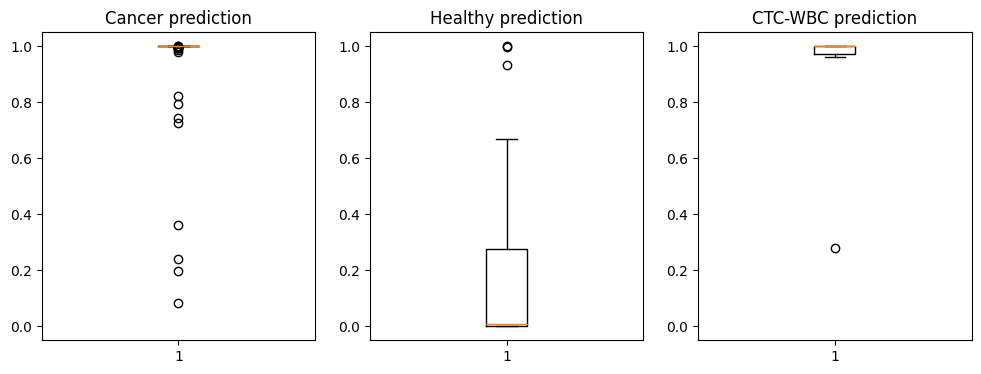

In [8]:
vis = Visualisation(lgbm_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

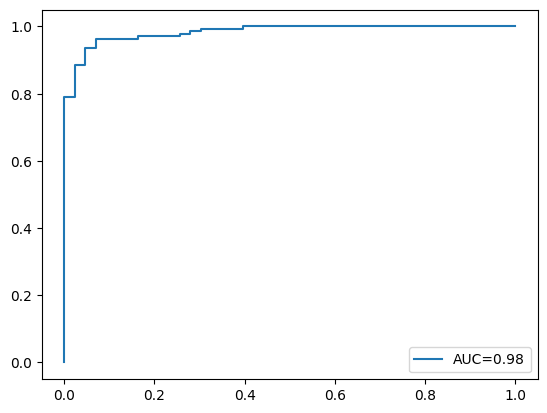

In [9]:
vis.draw_roc_curve_from_probabilities()

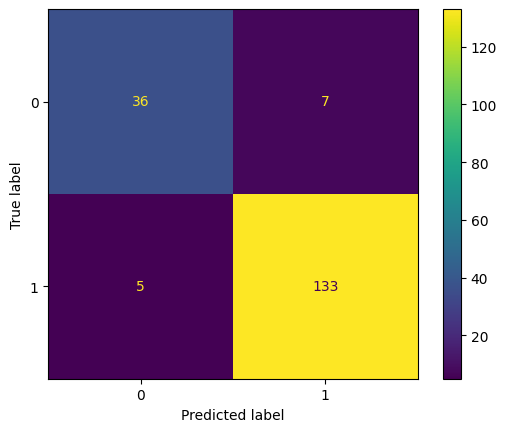

In [10]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [11]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.8913507989594947
Training balanced accuracy 1.0

Validation roc auc 0.9746841322928278
Training roc auc 1.0

Validation precision 0.9621816455670742
Training precision 1.0

Validation recall 0.9130434782608695
Training recall 1.0

Validation f1 0.93621015999189
Training f1 1.0



In [12]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.883777103696214

Test roc auc 0.9752836759914617

Test precision 0.9412707390648567

Test recall 0.9613526570048311

Test f1 score 0.9510509891440376


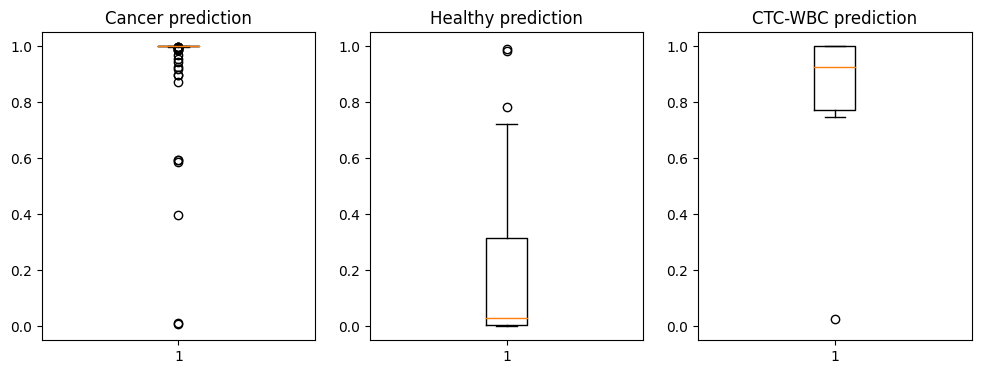

In [13]:
vis = Visualisation(lgbm_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

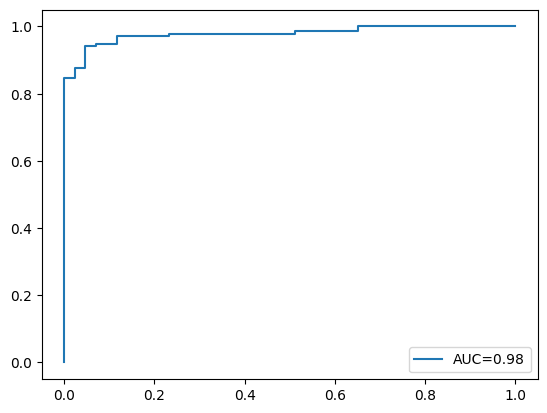

In [14]:
vis.draw_roc_curve_from_probabilities()

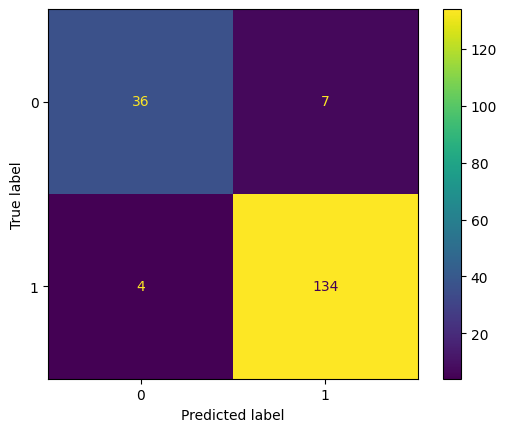

In [15]:
vis.display_confusion_matrix()

### XGBoost

In [16]:
healthy_cells_train_indices = np.where(data_object.train_classes == 0)[0]
cancer_cells_train_indices = np.where(data_object.train_classes == 1)[0]

class_weight = len(healthy_cells_train_indices) / len(cancer_cells_train_indices)

xgb_clf = XGBClassifier(
    booster="gbtree",
    eta=0.2,
    #min_child_weight=4,  # Jedyna zmiana w porownaniu do poprzedniego podzialu
    max_depth=8,
    gamma=0.01,   
    scale_pos_weight=class_weight,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [17]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.8969249349684132
Training balanced accuracy 0.9909420289855072

Validation roc auc 0.9731047937569678
Training roc auc 1.0

Validation precision 0.9690058479532163
Training precision 1.0

Validation recall 0.8985507246376812
Training recall 0.9818840579710145

Validation f1 0.9310134310134309
Training f1 0.9907710989678202



In [18]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.895657791259409

Test roc auc 0.9813223233344569

Test precision 0.9499398749398749

Test recall 0.9541062801932366

Test f1 score 0.951708042549412


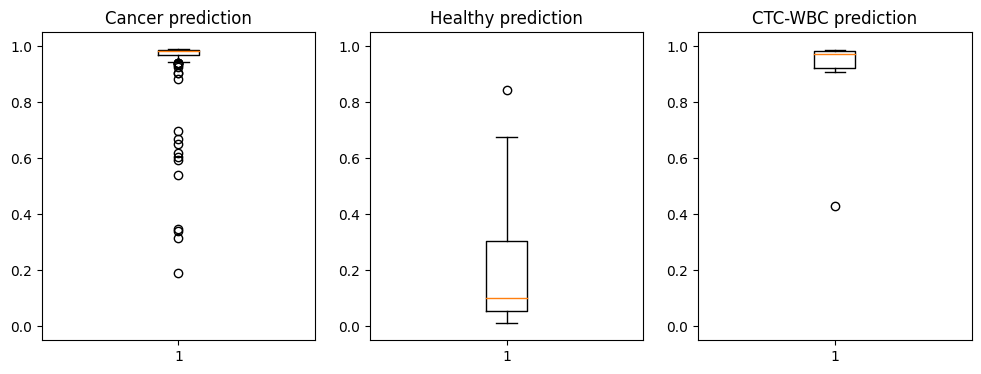

In [19]:
vis = Visualisation(xgboost_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

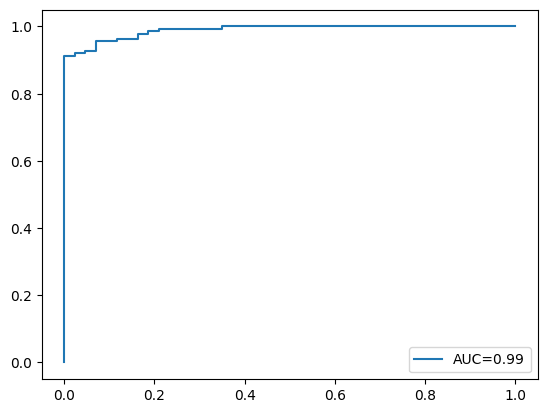

In [20]:
vis.draw_roc_curve_from_probabilities()

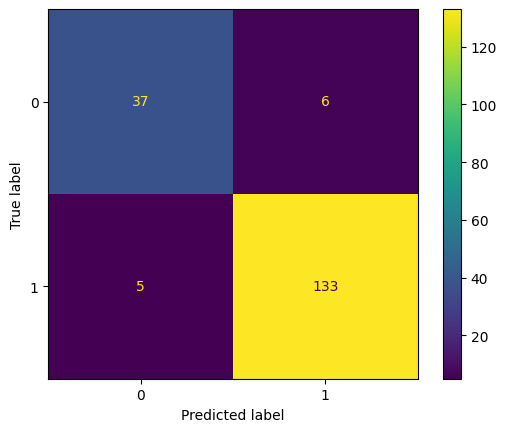

In [21]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [22]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9298123374210331
Training balanced accuracy 1.0

Validation roc auc 0.9757525083612041
Training roc auc 1.0

Validation precision 0.9846723044397464
Training precision 1.0

Validation recall 0.9130434782608696
Training recall 1.0

Validation f1 0.9473015053022803
Training f1 1.0



In [23]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.8694809571958206

Test roc auc 0.9723626558813617

Test precision 0.9323911513427184

Test recall 0.9637681159420289

Test f1 score 0.9477866493938532


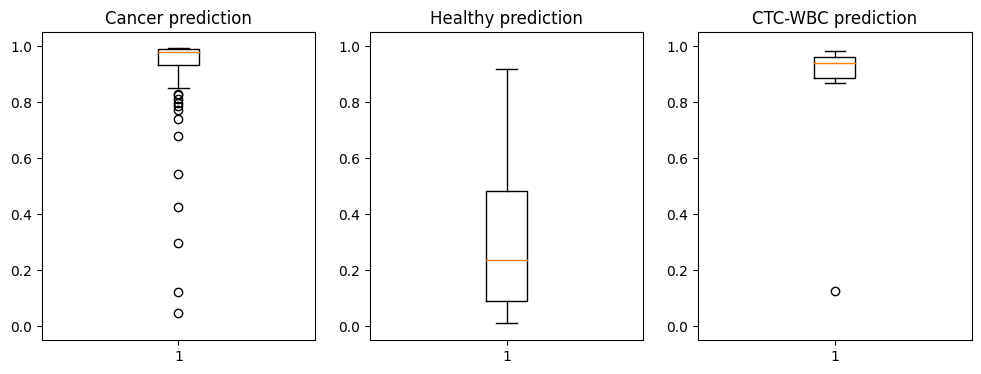

In [24]:
vis = Visualisation(xgboost_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

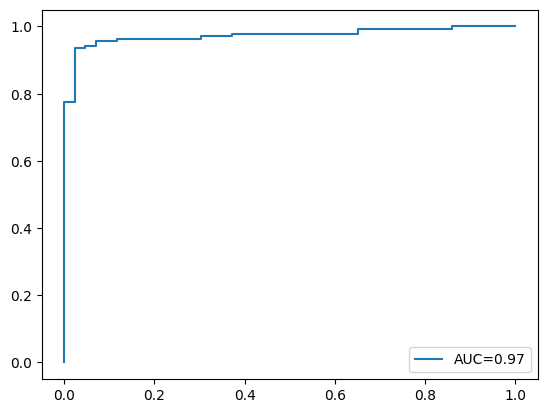

In [25]:
vis.draw_roc_curve_from_probabilities()

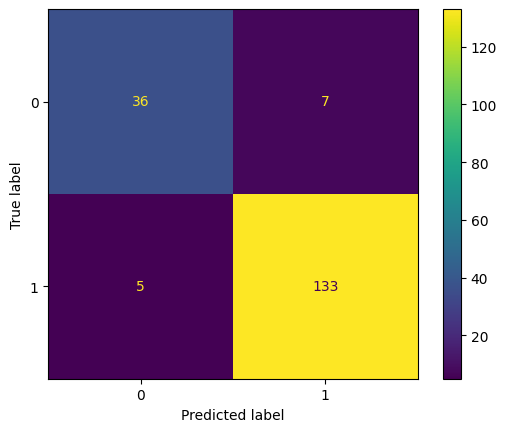

In [26]:
vis.display_confusion_matrix()

### Random Forest

In [27]:
rf_clf = RandomForestClassifier(  
    criterion="log_loss",
    n_estimators=2000,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [28]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9320884429580082
Training balanced accuracy 1.0

Validation roc auc 0.9929394277220364
Training roc auc 1.0

Validation precision 0.9711476466795617
Training precision 1.0

Validation recall 0.9710144927536232
Training recall 1.0

Validation f1 0.9708482676224612
Training f1 1.0



In [29]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8936917200314571

Test roc auc 0.9901134703965847

Test precision 0.9440420655999917

Test recall 0.9734299516908212

Test f1 score 0.9584364281051038


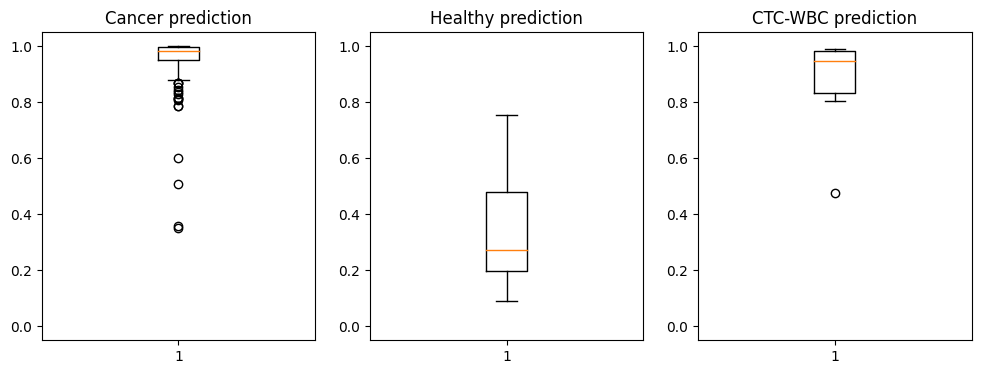

In [30]:
vis = Visualisation(rf_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

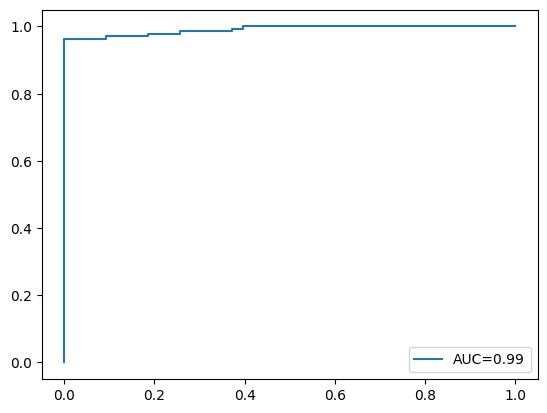

In [31]:
vis.draw_roc_curve_from_probabilities()

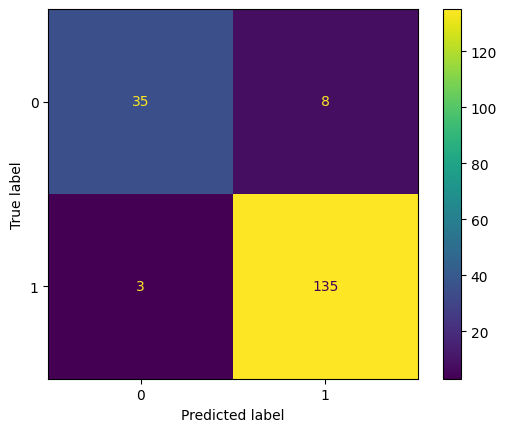

In [32]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [33]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.8906075808249722
Training balanced accuracy 1.0

Validation roc auc 0.9823950204384987
Training roc auc 1.0

Validation precision 0.9448696145124718
Training precision 1.0

Validation recall 0.9927536231884058
Training recall 1.0

Validation f1 0.9681970884658454
Training f1 1.0



In [34]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8365071340298843

Test roc auc 0.9863217615998202

Test precision 0.9106621508562904

Test recall 0.9830917874396136

Test f1 score 0.9454417134615974


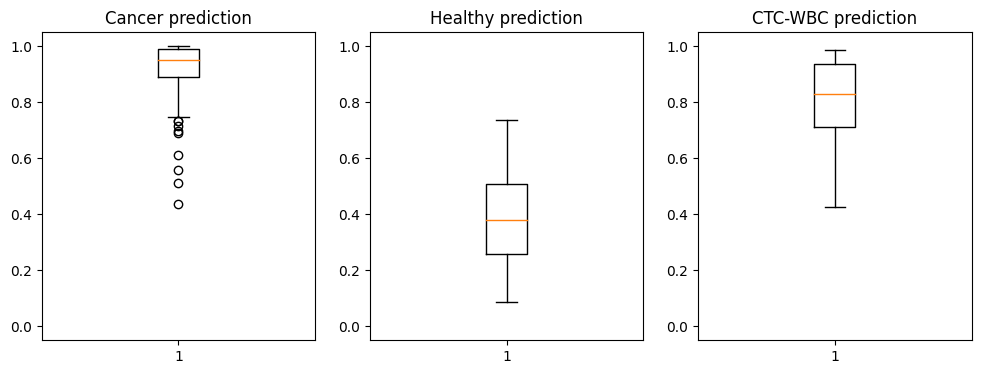

In [35]:
vis = Visualisation(rf_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

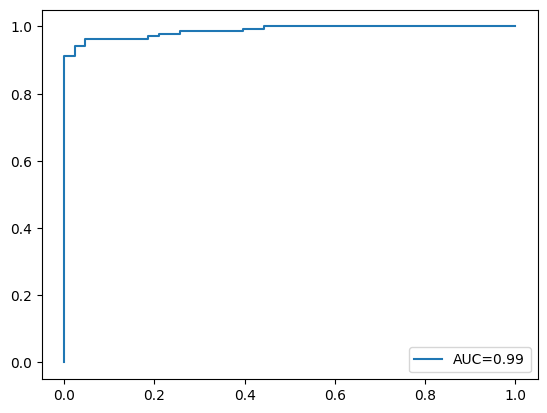

In [36]:
vis.draw_roc_curve_from_probabilities()

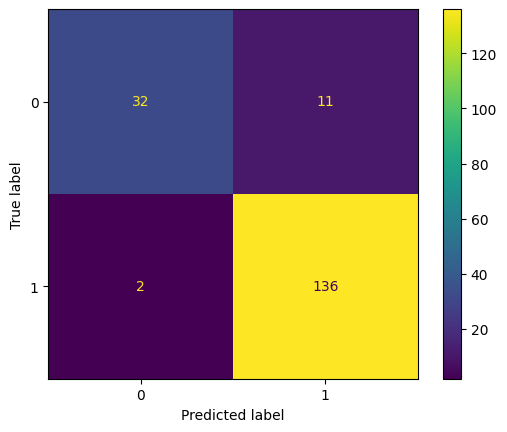

In [37]:
vis.display_confusion_matrix()

### Balanced Random Forest

In [38]:
brf_clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    class_weight="balanced",
    criterion="entropy",
    oob_score=True,  
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [39]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9565217391304347
Training balanced accuracy 0.9746376811594203

Validation roc auc 0.9877833519137867
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.9130434782608695
Training recall 0.9492753623188407

Validation f1 0.9539056571442558
Training f1 0.9739281961007489



In [40]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9574205145489271

Test roc auc 0.9889900011234692

Test precision 0.9852025215544306

Test recall 0.9613526570048309

Test f1 score 0.9731105452548068


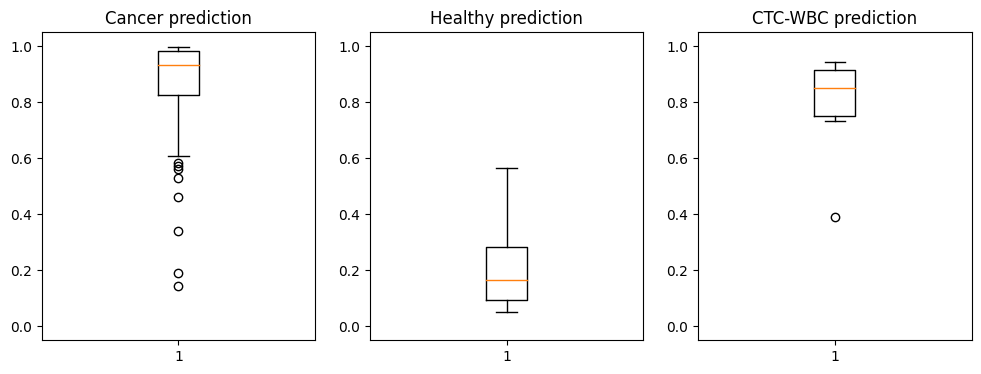

In [41]:
vis = Visualisation(brf_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

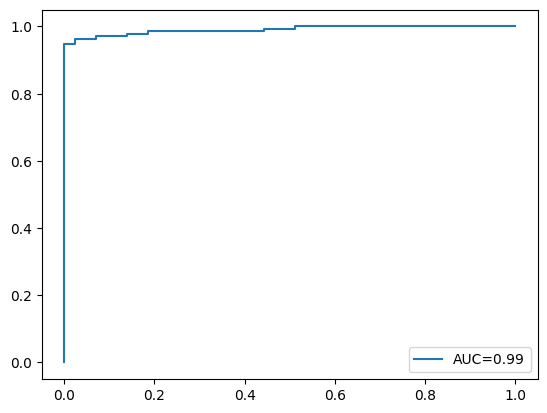

In [42]:
vis.draw_roc_curve_from_probabilities()

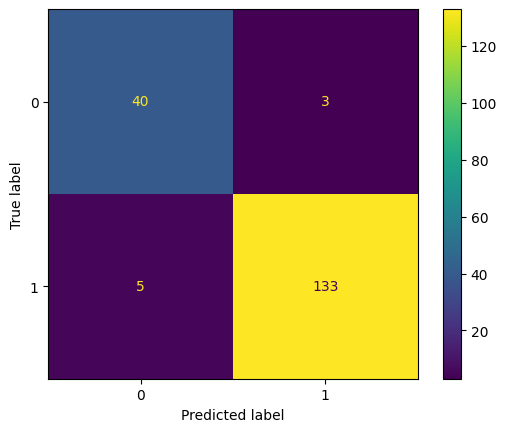

In [43]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [44]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9334355258268302
Training balanced accuracy 0.9800724637681159

Validation roc auc 0.9857859531772576
Training roc auc 1.0

Validation precision 0.9850168350168351
Training precision 1.0

Validation recall 0.9202898550724639
Training recall 0.9601449275362318

Validation f1 0.9509403602426859
Training f1 0.9796392892784755



In [45]:
brf_model_object.display_test_results()

Test balanced accuracy 0.954752275025278

Test roc auc 0.986574542186271

Test precision 0.9828418061086834

Test recall 0.9637681159420289

Test f1 score 0.9731909593674298


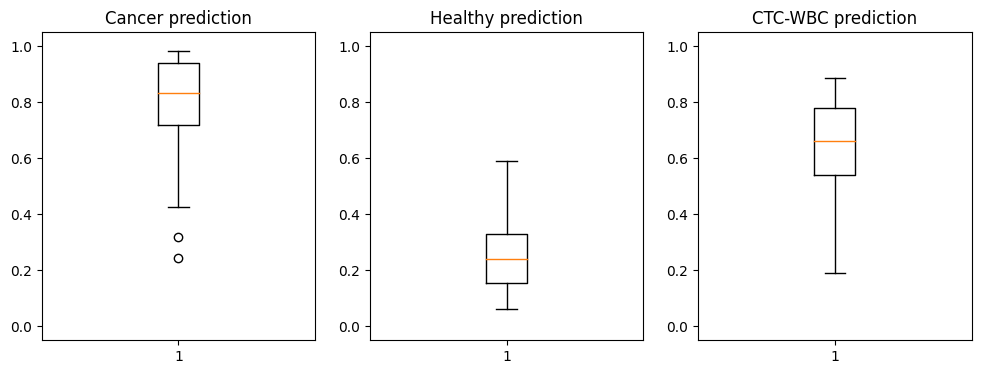

In [46]:
vis = Visualisation(brf_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot()

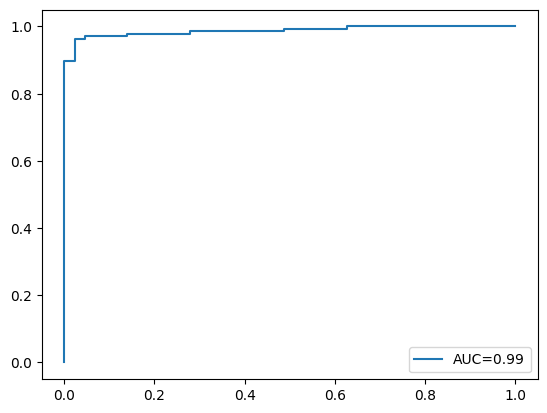

In [47]:
vis.draw_roc_curve_from_probabilities()

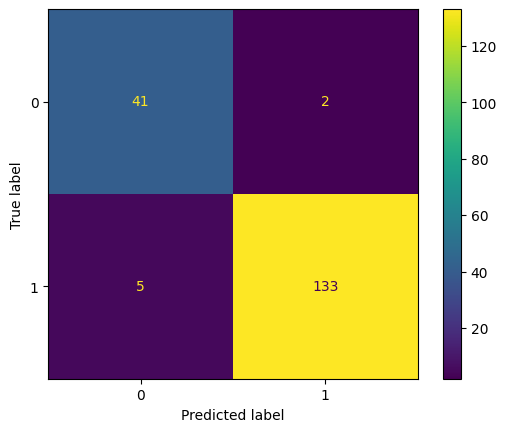

In [48]:
vis.display_confusion_matrix()